In [1]:
!pwd

/


## Setting the directory for DataProc

In [2]:
%cd /media/w261-s22-Anand-Patel-95/Assignments/HW4/docker/student/

/media/w261-s22-Anand-Patel-95/Assignments/HW4/docker/student


In [3]:
!pwd

/media/w261-s22-Anand-Patel-95/Assignments/HW4/docker/student


## Getting the data

In [6]:
!gsutil ls gs://w261-hw-data/main/Assignments/HW4/docker/student/

gs://w261-hw-data/main/Assignments/HW4/docker/student/
gs://w261-hw-data/main/Assignments/HW4/docker/student/wines.zip


In [7]:
!gsutil cp gs://w261-hw-data/main/Assignments/HW4/docker/student/wines.zip .

Copying gs://w261-hw-data/main/Assignments/HW4/docker/student/wines.zip...
/ [1 files][ 90.9 KiB/ 90.9 KiB]                                                
Operation completed over 1 objects/90.9 KiB.                                     


In [8]:
!unzip wines.zip

Archive:  wines.zip
   creating: data/
  inflating: data/whites.csv         
  inflating: data/reds.csv           


# HW 4 - Supervised Learning at Scale.
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the first three homeworks you became familiar with the Map-Reduce programming paradigm as manifested in the Hadoop Streaming and Spark frameworks. We explored how different data structures and design patterns can help us manage the computational complexity of an algorithm. As part of this process you implemented both a supervised learning alogorithm (Naive Bayes) and an unsupervised learning algorithm (synonym detection via cosine similarity). In both of these tasks parallelization helped us manage calculations involving a large number of features. However a large feature space isn't the only situation that might prompt us to want to parallelize a machine learning algorithm. In the final two assignments we'll look at cases where the iterative nature of an algorithm is the main driver of its computational complexity (and the reason we might want to parallelize it).

In this week's assignment we'll perform 3 kinds of linear regression: OLS, Ridge and Lasso. As in previous assignments you will implement the core calculations using Spark RDDs... though we've provided more of a code base than before since the focus of the latter half of the course is more on general machine learning concepts. By the end of this homework you should be able to:  
* ... __define__ the loss functions for OLS, Ridge and Lasso regression.
* ... __calculate__ the gradient for each of these loss functions.
* ... __identify__ which parts of the gradient descent algorithm can be parallelized.
* ... __implement__ parallelized gradient descent with cross-validation and regularization.
* ... __compare/contrast__ how L1 and L2 regularization impact model parameters & performance.

Additional Reference: [Spark 3.0.0 Documentation - RDD programming guide](https://spark.apache.org/docs/3.0.0/rdd-programming-guide.html)

__Please refer to the `README` for homework submission instructions and additional resources.__

### Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os

In [2]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw4_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/19 20:00:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

# Question 1: Opimization Theory 

As you know from w207, Gradient Descent is an iterative process that seeks to find the optimal parameters for a model given a particular training data set. It does this by using the vector of partial derivatives of a loss function to strategically update parameters in a way that will reduce the loss. In live session 6 you discussed some of the theory behnid why gradient descent works and looked at a small example of gradient descent in the context of linear regression.

### Q1 Tasks:

* __a) short response:__ What are the first and second order conditions for convexity and why do we care about them when performing Gradient Descent?

* __b) short response:__ Explain the relationship between problem domain space and model parameter space in the context of Gradient Descent. In practice, why can't we find the optimal model by simply looking at the error surface in model parameter space?

* __c) short response:__ In the context of Gradient Descent, what is the 'learning rate' and what are the tradeoffs associated with setting this hyperparameter?

* __d) BONUS:__ In the context of OLS, what do we mean by a 'closed form solution' and why is it not scalable?

### Q1 Student Answers:
> __a)__ For a function to be convex, the 1st order condition is that the function's derivative must be equal to 0. The 2nd order condition is that the function's 2nd derivative must be positive, meaning the function is increasing everywhere. An input to the function that satisfies both of these conditions indicated a minimum of the function at that input value. We care about this for gradient descent because we know that as we follow the gradient, we are approaching an absolute minimum for the loss function (if it is a convex function). 

> __b)__ The problem domain space is the space where we can plot the predictors and the target of the problem we are solving. The model parameter space is the space where we can plot the model's parameters we seek and the loss function value we want to minimize. We can't find the optimal model by looking at the error surface in the model parameter space because we do not have access to the parameter space or the error surface; it is not possible to generate all these points to form the surface. That's why we use gradient descent to find the minimum. 

> __c)__ The learning rate captures how much we change our parameters on each gradient descent step. A larger learning rate means we should converge to an optimal solution faster, but too high of a learning rate means we could never converge because we might overshoot the optimal solution each time we update our parameters with such a large step. 

> __d)__ In OLS, the closed form solution is a derived analytical solution for the line that minimizes the mean squared error on the data. This can be thought of as the exact, correct solution for line of best fit. We cannot scale this closed form solution because it involves computing the inverse of a matrix, which is difficult to do in parallel. The matrix will grow larger with larger datasets, so the closed form solution does not help us solve the problem since we will not be able to compute the matrix inverse.

# About the Data

For the main task in this portion of the homework you will use data about red and white Portuguese wines. [This data](http://archive.ics.uci.edu/ml/datasets/Wine+Quality) was made available to the UC Irvine public repository of Machine Learning datasets by researchers at the University of Minho in association with [this paper](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub):
> P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

The dataset includes 12 fields:
>`fixed acidity`  
`volatile acidity`  
`citric acid`  
`residual sugar`  
`chlorides`  
`free sulfur dioxide`  
`total sulfur dioxide`  
`density`  
`pH`  
`sulphates`  
`alcohol`  
`quality`   -- (_a score between 0 and 10_)

__`IMPORTANT NOTE:`__ The outcome variable in our data is a human assigned score ranging from 0 to 10. Since the scores are integers this is actually an ordinal and not numerical outcome varaible. However for the purposes of this assignment we'll treat it as a numerical quantity.

The data are in two files: one containing red wines and another containing white wines.  Use the following cells to download the data, add a field for red/white, and split it into a test and train set.

In [5]:
# make a data folder & download red & white wine files
!mkdir data
!wget -q -O data/reds.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget -q -O data/whites.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [5]:
# extract header fields - RUN THIS CELL AS IS
header = !head -n 1 data/reds.csv
header = header[0]
FIELDS = ['color'] + re.sub('"', '', header).split(';')

In [6]:
# load the raw data into an RDD - RUN THIS CELL AS IS
redsRDD = sc.textFile('data/reds.csv')\
            .filter(lambda x: x != header)\
            .map(lambda x: '1;' + x) # set first field 1 to indicate red wine
whitesRDD = sc.textFile('data/whites.csv')\
              .filter(lambda x: x != header)\
              .map(lambda x: '0;' + x) # set first field 0 to indicate white wine

In [7]:
redsRDD.take(5)

['1;7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5',
 '1;7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5',
 '1;7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;9.8;5',
 '1;11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58;9.8;6',
 '1;7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5']

In [8]:
whitesRDD.take(5)

['0;7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6',
 '0;6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9.5;6',
 '0;8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;10.1;6',
 '0;7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4;9.9;6',
 '0;7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4;9.9;6']

In [9]:
# Generate 80/20 (pseudo)random train/test split - RUN THIS CELL AS IS
trainRDD, heldOutRDD = redsRDD.union(whitesRDD).randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 1316 records for evaluation and assigned 5181 for training.


In [10]:
# helper function - RUN THIS CELL AS IS
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split(';'), dtype = 'float')
    features,quality = fields[:-1], fields[-1]
    return(features, quality)

In [11]:
# cache the training set - RUN THIS CELL AS IS 
trainRDDCached = trainRDD.map(parse).cache()

In [12]:
trainRDDCached.take(5)

[(array([ 1.    ,  7.4   ,  0.7   ,  0.    ,  1.9   ,  0.076 , 11.    ,
         34.    ,  0.9978,  3.51  ,  0.56  ,  9.4   ]),
  5.0),
 (array([1.00e+00, 7.80e+00, 7.60e-01, 4.00e-02, 2.30e+00, 9.20e-02,
         1.50e+01, 5.40e+01, 9.97e-01, 3.26e+00, 6.50e-01, 9.80e+00]),
  5.0),
 (array([ 1.   , 11.2  ,  0.28 ,  0.56 ,  1.9  ,  0.075, 17.   , 60.   ,
          0.998,  3.16 ,  0.58 ,  9.8  ]),
  6.0),
 (array([ 1.    ,  7.4   ,  0.7   ,  0.    ,  1.9   ,  0.076 , 11.    ,
         34.    ,  0.9978,  3.51  ,  0.56  ,  9.4   ]),
  5.0),
 (array([ 1.    ,  7.4   ,  0.66  ,  0.    ,  1.8   ,  0.075 , 13.    ,
         40.    ,  0.9978,  3.51  ,  0.56  ,  9.4   ]),
  5.0)]

# Question 2: EDA

A statistician's approach to Linear Regression typically involves a series of EDA steps to examine each feature in the data and then a series of steps to test assumptions about their potential contribution to a multi-feature linear model. In particular, we'd want to look for a set of features that exhibit a likely linear relationship with the outcome variable and that are _not_ highy correlated with each other. In the context of machine learning, these considerations remain important techniques for improving model generalizability despite the common practice to use model evaluation techniques (and large data sets) to get the final word on feature selection. 

In this question we'll briefly look at the features in our data set. To mimic an 'at scale' analysis we'll start by sampling from our Spark RDD training set so that we have a manageable amount of data to work with in our visuals.

### Q2 Tasks:
* __a) short response:__ Run the provided code to sample 1000 points and visualize histograms of each feature. Comment on the distributions you observe (eg. _Which features appear normaly distributed, which don't? Which features vary most/least?_) How is the varaible `color` different than the other features & what does that mean about how we interpret its regression coefficient?

* __b) short response:__ Run the provided code to create boxplots of each feature. Which, if any, appear to have a positive linear relationship with `quality`? Which if any appear to have a negative linear relationship with `quality`?


* __c) short response:__ Run the provided code to plot the correlations matrix. Which pairs of features are most _strongly_ (postively or negatively) associated with each other? What implications would that have for our feature selection?

### Q2 Student Answers:
> __a)__ We observe several distributions for our features. 
> 
> - Normally distributed features: citric acid (varies a lot), density (varies moderately), pH (varies a lot), alcohol (varies a lot). 
> - Right tail skewed: fixed acidity (besides the tail, varies moderately), volatile acidity (varies a lot), residual sugar (concentrated around 0, does not vary much), sulphates (varies moderately), 
> - Weird distributions: chlorides (spiked and concentrated around a low value, does not vary much), free sulfrur dioxide (concentrated around lower values, varies moderately), total sulfur dioxide  (varies a lot, almost forming a bimodal distribution with lower values).
>
> - Color: color appears to be a binary feature because it only takes on values of 0 or 1, unlike the other continuous variables. This means we interpret its regression coefficient as the added effect of the wine having color (`color = 1`) vs. it not having color. 
>

> __b)__ Reading the boxplots, we would observe a positive linear relationship with quality if the boxes going further up (higher quality) are concentrated further right (higher feature value); the boxes are ascending diagonally towards top right. A negative linear relationship with quality is observed if the boxes going further up (higher quality) are concentrated further left (lower feature value); the boxes are descending diagonally towards bottom right.
>
> - Positive linear relationship with `quality`: citric acid (approximately), free sulfur dioxide (approximately), total sulfur dioxide, pH ( slightly).
> - Negative linear relationship with `quality`: fixed acidity (slightly), volatile acidity (slightly), chlorides (slightly), density.
> 

> __c)__ Reading the correlation matrix heatmap, the strongest positive correlations are the deepest red in color while the strongest negative correlations are the deepest blue in color. 
> - The feature pairs with the strongest positive correlation are: `volatile acidity & color`, `total sulfur dioxide & free sulfur dioxide`, `density & residual sugar`. 
> - The feature pairs with the strongest negative correlation are: `total sulfur dioxide & color`, `alcohol & density`. 
>
> These strongly correlated features imply that our feature selection will probably be able to use just one of these pairs to best describe quality in our model. When features are strongly correlated, the value of one of them will give information about the other feature. If they have an established relationship, the information provided by including both of them will be minimal so I suspect that feature selection will keep the feature from the pair that works better at discriminating quality and drop the other one, to reduce overfitting.

In [16]:
# part a - take a 1000 point sample for EDA (RUN THIS CELL AS IS)
sample = np.array(trainRDDCached.map(lambda x: np.append(x[0], [x[1]]))
                                .takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

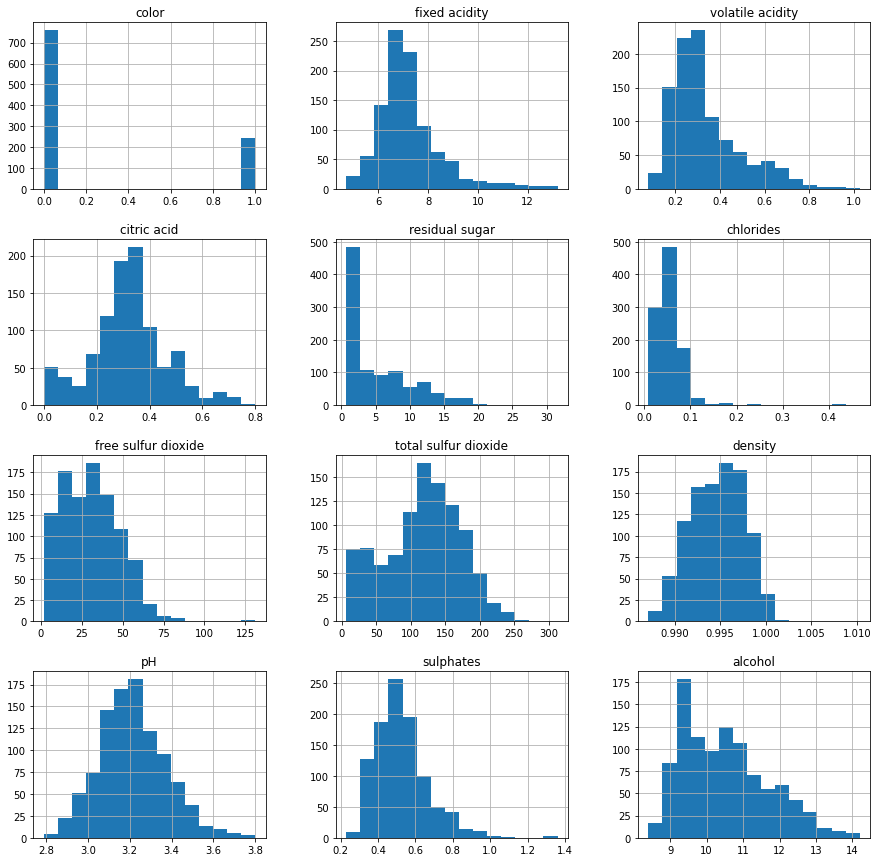

In [17]:
# part a - take a look at histograms for each feature (RUN THIS CELL AS IS)
sample_df[FIELDS[:-1]].hist(figsize=(15,15), bins=15)
plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argumen

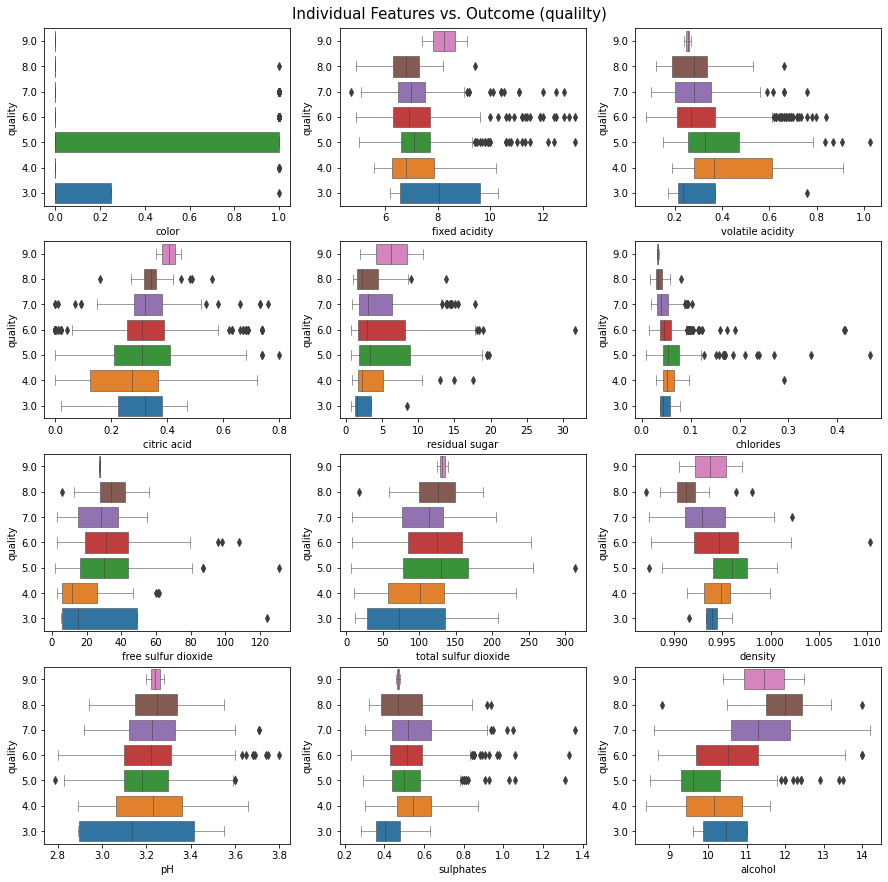

In [18]:
# part b -  plot boxplots of each feature vs. the outcome (RUN THIS CELL AS IS)
fig, ax_grid = plt.subplots(4, 3, figsize=(15,15))
y = sample_df['quality']
for idx, feature in enumerate(FIELDS[:-1]):
    x = sample_df[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
plt.show()

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


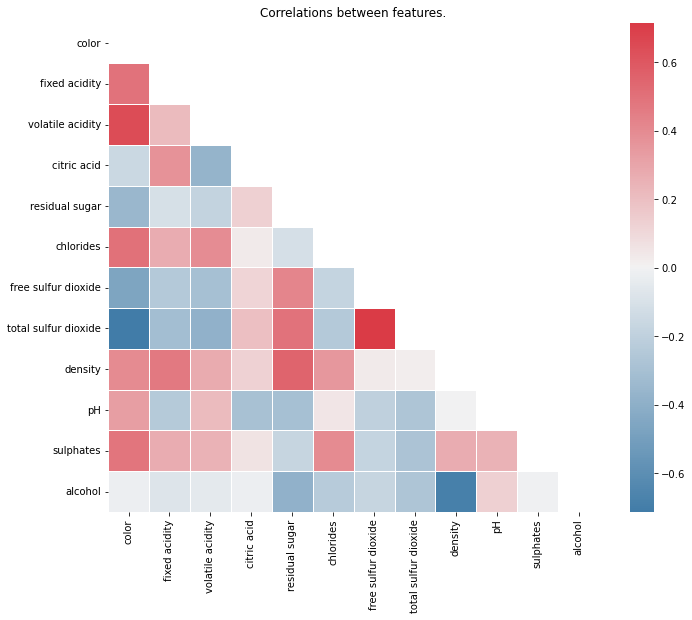

In [19]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = sample_df[FIELDS[:-1]].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

# Question 3: OLS Loss

For a parametric model, the key factor that will impact how easy it is to optimize is your choice of how to define the loss function. In Ordinary Least Squares (OLS) Regression our loss function is just about as convenient as you will get: not only is it convex, its also very easy to interpret. 

When doing supervised learning, a simple sanity check consists of comparing one’s estimator against simple rules of thumb. It is useful as a simple baseline to compare with other (real) regressors. Examples of regression baselines include:
* "mean": always predicts the mean of the training set
* "median": always predicts the median of the training set
* "quantile": always predicts a specified quantile of the training set,provided with the quantile parameter.
* "constant": always predicts a constant value that is provided by the user.

In this question you'll "choose" a baseline model and then write a function to compute the loss of a linear model in Spark. You'll reuse this function in Q4 when you implement gradient descent.

#### Baseline example illustrated:

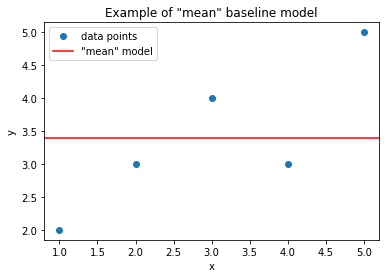

In [20]:
# points from our mini example from the demo 6 notebook (RUN THIS CELL AS IS)
points = np.array([[1,2],[3,4],[5,5],[4,3],[2,3]])
x = points[:,0]
y = points[:,1]

plt.figure()
plt.plot(x, y,'o', label='data points')
plt.axhline(np.mean(y),c='r', label='"mean" model')
plt.title('Example of "mean" baseline model')
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
plt.show()

### Q3 Tasks:
* __a) code:__ Fill in the code below to compute the mean and variance of your outcome variable. [__`HINT:`__ _use `trainRDDCached` as the input & feel free to use Spark built-in functions._]


* __b) short response:__ Write the formula for the OLS loss function and explain how to interpret it graphically.


* __c) short response:__ In the context of linear models & vector computations what does it mean to 'augment' a data point and why do we do this?


* __d) code + short response:__ Fill in the missing code to complete the`OLSLoss` function. Is computing the loss "embarassingly parallel'? Explain. [__`TIP:`__ Use `augmentedData` as your input when computing the loss.]

* __e) code + short response:__ Fill in the missing code to define a baseline model for this data set that has a bias term equal to the mean of your outcome variable and `0.0` for all coefficients. Note that in the docstring for `OLSLoss` we specified that the model should be a numpy array with the bias in the first position. Once you've defined your model, run the provided cells to check that your model has the correct dimensions and then compute the loss for your baseline model. Compare your results to the result you got in `part a` and explain what you see.

### Q3 Student Answers:
> __b)__ The equation for the OLS loss function is the average sum of squared errors:
>
> $$
\mathbf{x}' :=
\begin{bmatrix}
1\\
\mathbf{x}
\end{bmatrix},\quad
\boldsymbol{\theta} :=
\begin{bmatrix}
b\\
\mathbf{w}
\end{bmatrix}
$$
>
> \begin{equation}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i\right]^2
\end{equation}
>
> In the model parameter space: If we plotted the OLS loss function, for a 2 parameter case, we could expect the loss to look like a 3D cup like surface where the height is the the loss. This surface is convex, so it will have a minimum point at the bottom. To find the parameters for this minimum loss value, we use a technique like gradient descent to get to the minimum point in the plot where the loss fuction value is smallest.
>
> In the problem domain space: We interpret this graphically as the line that minimizes the errors to the data points (distances from the line to the points) such that the loss function is the lowest. The error can be interpreted graphically as drawing a vertical line from the data point to the line, and squaring this vertical line's distance. To compute the loss: for each prediction along the line, we compute the squared error inside the sum for the loss function above, sum up these losses, and take the average. The line that minimizes this loss function will balance out the vertical lines between the line and the data points, that capture the error of our estimates. It will look like the line that best fits this data.


> __c)__ Augmenting a data point means adding an extra row or column to the datapoint, as we do above by by setting $x_{m+1}=1$. We do this so that we can write our loss function more simply. Our prediction will be the dot product between two vectors now: our parameters $\theta$ (including weights and bias) and our augmented datapoint $x$ (actual data points and 1 for the bias product). Computing a dot product in one place for the prediction is cleaner to interpret and efficient using numpy.

> __d)__ Computing the loss is embarassingly parallel because it can be done row by row for each data point since we can compute and emit squared error, which can be distributed to workers in parallel. The final calculation of mean squared error can be done through an aggregation like reduce or `.mean()`. The parallel processes do not need to communicate to each other at all during this process.

> __e)__ When we set the baseline to have 0 weights for the features' coefficients and the mean of `quality` for the bias, we get our OLS loss to be the same as our variance from part a: `0.760086564865664`. The baseline line we produced is just always predicting the mean value of `quality` for every data point. The OLS Loss is the mean squared error of our predictions, and guessing the mean of our prediction variable each time will produce a loss equal to the variance of the prediction variable since we are dealing with an unbiased estimator. The variance just measures the dispersion of the values around the mean; the MSE indicates how different the values of the estimator and the actual values of the parameters are. The MSE is a comparison of the estimator and the true parameter, as it were. If our estimate is always the mean, then the MSE measures dispersion around the mean, just like variance does.
>
> Source: https://math.stackexchange.com/a/1357987


In [13]:
# part a - mean and variance of the outcome variable 
meanQuality = trainRDDCached.map(lambda x: x[1]).mean() # FILL IN YOUR CODE HERE
varQuality = trainRDDCached.map(lambda x: x[1]).variance() # FILL IN YOUR CODE HERE
print(f"Mean: {meanQuality}")
print(f"Variance: {varQuality}")

Mean: 5.811040339702759
Variance: 0.760086564865664


In [14]:
# part d - write function to compute loss (FILL IN MISSING CODE BELOW)
def OLSLoss(dataRDD, W):
    """
    Compute mean squared error.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    ################## YOUR CODE HERE ##################
    # broadcast W
    W_bc = sc.broadcast(W)
    
    cost = lambda x: (np.dot(W_bc.value, x[0]) - x[1])**2 # Squared Error
    
    loss = augmentedData.map(cost).mean() # MSE
    ################## (END) YOUR CODE ##################
    return loss

In [38]:
temp = (np.array([1.00e+00, 7.80e+00, 7.60e-01]), 5.0)

temp_lambda = lambda x: (np.append([1.0], x[0]), x[1])

temp2 = temp_lambda(temp)

W_temp = np.array([.5, 1, .6, -.3])

cost = lambda x: (np.dot(W_temp, x[0]) - x[1])**2 # Squared Error

cost(temp2)



0.9063039999999999

In [15]:
# part e - define your baseline model here
BASELINE = np.array([meanQuality, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
# part e - compute the loss for your baseline model (RUN THIS CELL AS IS)
assert len(BASELINE) == len(trainRDDCached.take(1)[0][0]) + 1, "Double check model dimensions"
print(f"Baseline model loss: {OLSLoss(trainRDDCached, BASELINE)}")

Baseline model loss: 0.7600865648656636


# Question 4: Vanilla Gradient Descent

Performing Gradient Descent technically only requires two steps: 1) _use the current model to calculate the gradient_; 2) _use the gradient to update the current model parameters_. In practice though, we'll want to add a third step which is to compute the loss for our new model so that we can see if its working. In this question you'll implement gradient descent for OLS regression and take a look at a few update steps.

### Q4 Tasks:
* __a) short response:__ Jimi describes the main part of the gradient calculation for OLS Regression using a short mantra: _'the mean of the data weighted by the errors'_. . Write the formula for the gradient and explain how it reflects this phrase. 

* __b) short response:__ Looking at the formula you wrote in `part a`, what parts of this calculation can be parallelized and what has to happen after reducing?


* __c) code:__ Fill in the missing lines in `GDUpdate` to compute the gradient and perform a single update of the model parameters.   
    * __`TIP 1:`__ _remember that the gradient is a vector of partial derivatives, `grad` should be a numpy array_    
    * __`TIP 2:`__ _Spark's built in `mean()` function may help you here_  


* __d) short response:__ Run the provided code to perform 5 steps of Gradient Descent on our data. What is wrong with these results?


* __e) code + short response:__ Fill in the missing code in `normalize` so that this function scales each feature and centers it at 0. Then use the provide code block to rerun your same gradient descent code on the scaled data. Use these results to explain what the problem was in 'd'.
    * __`TIP:`__ _You may find [this brief illustration](https://www.coursera.org/lecture/machine-learning/gradient-descent-in-practice-i-feature-scaling-xx3Da) from Andrew Ng's Coursera helpful._

### Q4 Student Answers:
> __a)__ Formula for the gradient calculation for OLS Regression:
>
> \begin{equation}
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum_{i=1}^{n}\left[ \boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i\right] \cdot \mathbf{x}'_i
\end{equation}
>
> This describes the *'the mean of the data weighted by the errors'* because the computation is a weighted average of the data points $\mathbf{x}'_i$ where the weights are the error terms $(\boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i)$. This is an average because we are summing together the weighted data points, and dividing by the total number of data points $n$.

> __b)__ The computation of everything to the right of the summation can be done in parallel on a row-by-row basis for each data point. We would need to reduce by taking the mean of these operations (summing and dividing by the total through reduces or `.mean()`) and multiply the result by 2. 

> __c)__ _complete the coding portions of this question before answering d & e_ 

> __d)__ These results are exploding the coefficients to very large numbers. This can happen when features have different scales they are measured on. We need to perform normalization for each of these features before we start modeling. Otherwise the gradient can take a long time to find its way to the global minimum, and the loss function is skewed in shape along the largely scaled parameters. In fact, we can see that the loss is not decreasing at every step.

> __e)__ The problem in 'd' was that the features were not normalized, so the loss was not decreasing with each gradient descent step. In our fixed implementation in 'e', we see that normalizing the features and running the same training lets our loss decrease from the baseline as we change our weights each iteration.

In [16]:
# part c - function to perform a single GD step
def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    
    ################## YOUR CODE HERE ################# 
    
    # helper_get_partials = lambda x: np.dot((np.dot(W, x[0]) - x[1]), x[0]) # individual gradient calc
    
    # broadcast the weight vector W
    W_bc = sc.broadcast(W)
    
    def helper_get_partials(x: tuple):
        """
        Helper function to compute the data point weighted by the error on a row-by-row basis
        """
        pred = np.dot(W_bc.value, x[0])
        error = pred - x[1]
        data_weighted = np.dot(error, x[0])
        return data_weighted
        
    grad = (augmentedData.map(helper_get_partials).mean()) * 2 # gradient calculation
    
    new_model = W - learningRate*grad # update weights with learning rate and gradient
    ################## (END) YOUR CODE ################# 
   
    return new_model

In [53]:
## testing it out - IGNORE
# model = BASELINE
# tmp_new_model, tmp_grad = GDUpdate(trainRDDCached, model)

In [54]:
%%time
# # part c - take a look at a few Gradient Descent steps (RUN THIS CELL AS IS)

nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(trainRDDCached, model)
    loss = OLSLoss(trainRDDCached, model)
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.7600865648656636
----------
STEP: 1
Loss: 3255.0397706648127
Model: [5.811, -0.009, -0.017, -0.007, 0.002, -0.035, -0.001, 0.167, -0.489, -0.0, 0.0, 0.001, 0.094]
----------
STEP: 2
Loss: 41538896320.90074
Model: [15.998, 0.946, 71.311, 3.109, 3.394, 67.104, 0.517, 372.213, 1469.681, 10.133, 32.587, 5.197, 105.407]
----------
STEP: 3
Loss: 5.321516254246975e+17
Model: [-36732.224, -3790.819, -257459.013, -11294.195, -12193.785, -240557.886, -1880.28, -1359608.579, -5252902.327, -36544.479, -117571.505, -18781.008, -379946.295]
----------
STEP: 4
Loss: 6.817355374095457e+24
Model: [131498780.95, 13574790.866, 921540888.277, 40426173.604, 43645471.549, 861027822.897, 6730358.366, 4867148463.848, 18801163135.814, 130805962.538, 420832007.136, 67225003.981, 1359973545.811]
----------
STEP: 5
Loss: 8.733663880159667e+31
Model: [-470665198626.592, -48587550191.15, -3298412689019.937, -144694834630.261, -156217444459.899, -3081821742976.596, -24089547803.278, -174206930645

In [17]:
# part d - helper function to normalize the data (FILL IN THE MISSING CODE BELOW)
def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """
    featureMeans = dataRDD.map(lambda x: x[0]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
    
    ################ YOUR CODE HERE #############
    # print(featureMeans)
    # print(featureStdev)
    
    # broadcast featureMeans, featureStdev
    
    # normalize by subracting features by their means and dividing by their standard deviations
    normedRDD = dataRDD.map(lambda x: ((x[0]-featureMeans)/featureStdev, x[1]))
    ################ FILL IN YOUR CODE HERE #############
    
    return normedRDD

In [56]:
# temp_data = (np.array([2, 4]), 6)
# temp_mean = [1, 1]
# temp_stdev = [2, 2]

# result = ((temp_data[0]-temp_mean)/temp_stdev, temp_data[1])

In [23]:
# normalize(trainRDDCached)

[2.48214630e-01 7.20537541e+00 3.40910056e-01 3.17083575e-01
 5.41987068e+00 5.60714148e-02 3.05365760e+01 1.15849064e+02
 9.94686398e-01 3.21915653e+00 5.30885929e-01 1.04929917e+01]
[4.31976999e-01 1.28178205e+00 1.66195687e-01 1.45495601e-01
 4.74397945e+00 3.59968247e-02 1.78675174e+01 5.66091266e+01
 2.99654173e-03 1.60177964e-01 1.47950049e-01 1.19978081e+00]


In [18]:
# part d - cache normalized data (RUN THIS CELL AS IS)
normedRDD = normalize(trainRDDCached).cache()

In [20]:
%%time
# part e - take a look at a few GD steps w/ normalized data  (RUN THIS CELL AS IS)
nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(normedRDD, model)
    loss = OLSLoss(normedRDD, model) 
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.7600865648656636
----------
STEP: 1
Loss: 0.6555276691703891
Model: [5.811, -0.02, -0.014, -0.045, 0.014, -0.007, -0.035, 0.009, -0.009, -0.054, 0.003, 0.008, 0.078]
----------
STEP: 2
Loss: 0.615059239044261
Model: [5.811, -0.022, -0.014, -0.071, 0.023, -0.006, -0.05, 0.014, -0.021, -0.079, 0.007, 0.024, 0.131]
----------
STEP: 3
Loss: 0.5935522582531458
Model: [5.811, -0.018, -0.01, -0.09, 0.03, 0.002, -0.057, 0.02, -0.032, -0.09, 0.011, 0.04, 0.167]
----------
STEP: 4
Loss: 0.5798853360580277
Model: [5.811, -0.014, -0.006, -0.105, 0.034, 0.012, -0.061, 0.026, -0.04, -0.094, 0.013, 0.054, 0.195]
----------
STEP: 5
Loss: 0.5703196233260643
Model: [5.811, -0.009, -0.003, -0.117, 0.036, 0.024, -0.063, 0.032, -0.047, -0.096, 0.016, 0.066, 0.217]
CPU times: user 90.1 ms, sys: 55.7 ms, total: 146 ms
Wall time: 1.67 s


# Question 5: Assessing the performance of your model.

Printing out the loss as we perform each gradient descent step allows us to confirm that our Gradient Descent code appears to be working, but this number doesn't accurately reflect "how good" our model is. In this question you'll plot error curves for a test and training set in order to discuss model performance. Note that although we split out a test & train set when we first loaded the data... in the spirit of keeping that 20% truly 'held out' until then end of the assignment, we'll make an additional split for the purposes of this question dividing the existing training set into two smaller RDDs.

### Q5 Tasks:
* __a) short response:__ Why doesn't the loss that we printed in Question 4 accurately reflect "how good" our model is? 


* __b) code:__ Since we're going to be running Gradient Descent a number of times let's package it into a function for convenience. Fill in the missing code in `GradientDescent()`, note that the missing code is going to look a lot like the provided code blocks in Q5 -- feel free to use those as a starting point.


* __c) short response:__ Use the provided code to split the normalized data into a test and train set, then run 50 iterations of gradient descent and plot the MSE curves for each. Describe what you see and speculate about why this might be happening.


* __d) short response:__ Note that passing the optional parameter `seed` to the Spark method `randomSplit` allows us to pseudo randomize our test/train split in a way that is replicable. Re-run the code for part 'c but this time in the line where we perform the `normedRDD.randomSplit` change the seed to _`seed = 5`_. What changes in the plot? Repeat for _`seed = 4`_. How does this change your interpret the results you saw in 'c'. What is the more likely explanation?

### Q5 Student Answers:
> __a)__ This loss is calculated on the training data, but does not reflect how good our model is at generalizing since we *expect* our trained model to improve on the training data. We need to compute the loss on some held out validation/test data to determine how good our model is. 

> __c)__ In all 3 plots, we see the training and testing loss decreasing with the number of iterations. This is because our model is improving throughout training via moving towards the model with minimum training loss through gradient descent. The losses flatline after a certain number of iterations and cease to go lower. This is because the training and test datasets both have irreducible error, and we can only minimize the reducible error. After minimizing the reducible error, we cannot lower the loss further. In the first plot, our training loss is less than our test loss the entire time. We expect this, since our model sees and trains on the training data. We evaluated our model on the test data, but none of those test examples change the model itself.

> __d)__ In the re-ran plots for `seed=5` and `seed=4`, we see the test loss begin lower than the training loss and the test loss stay lower than the training loss for all iterations respectively. The naive way to interpret these plots is to assume that our model generalizes amazingly, underfits, or just performs better on unseen data than training data. The more likely explanation is that the test-train splits here put different proportions of the data into the train and test set that may have different amounts of irreducible error. Basically, our single test-train split can be good or bad for training based on randomness so it makes interpreting these results a bit unreliable. Cross validation will solve the problem of the unreliable test-loss that we see here by averaging the losses across `k` different test-train splits that rotate out the held out dataset.

In [19]:
# part b - OLS gradient descent function
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## YOUR CODE HERE #############
        model = GDUpdate(trainRDD, model, learningRate)
        training_loss = OLSLoss(trainRDD, model)
        test_loss = OLSLoss(testRDD, model)
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [20]:
# plot error curves - RUN THIS CELL AS IS
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    plt.show()

In [23]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 50 iterations in 16.834664821624756 seconds


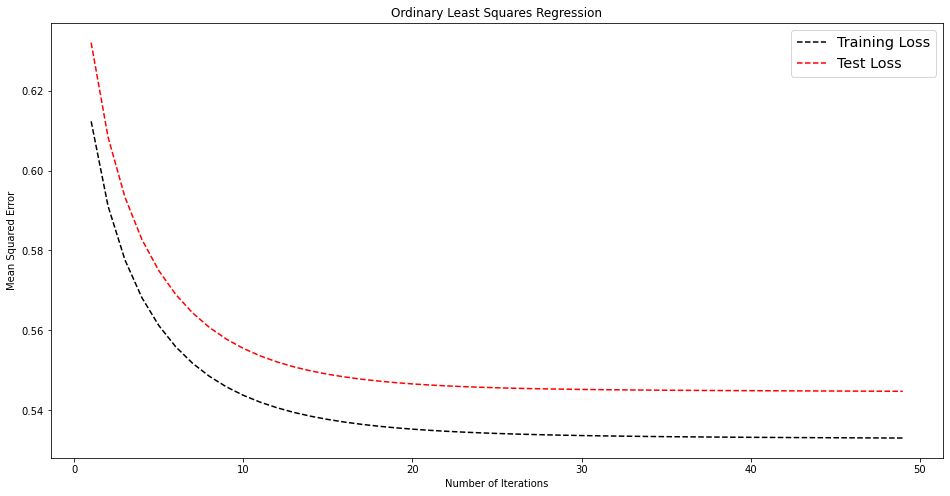

In [24]:
# take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

In [25]:
# save the models & their performance for comparison later (RUN THIS CELL AS IS)
np.savetxt(PWD + '/data/OLSmodels.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/OLSloss.csv', np.array([MSEtrain, MSEtest]), delimiter=',')

In [26]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 50 iterations in 17.226197004318237 seconds


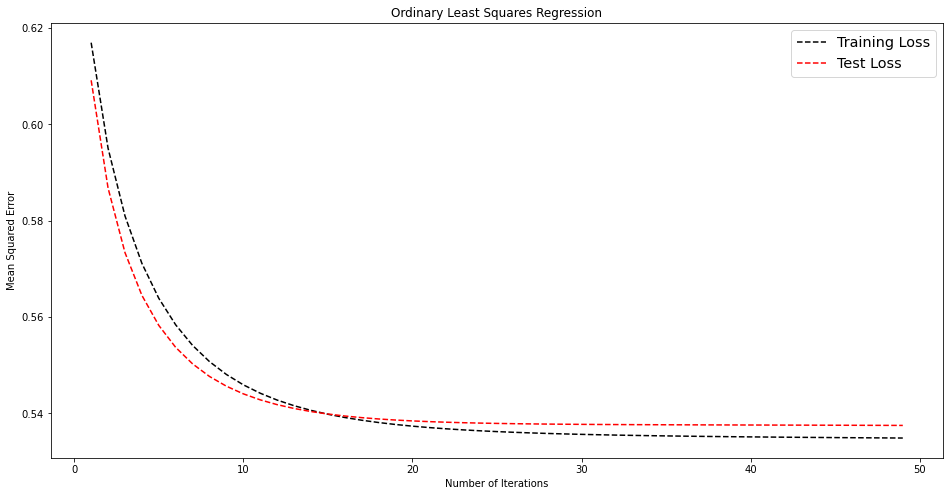

In [27]:
# take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

In [28]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 4)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 50 iterations in 14.48477578163147 seconds


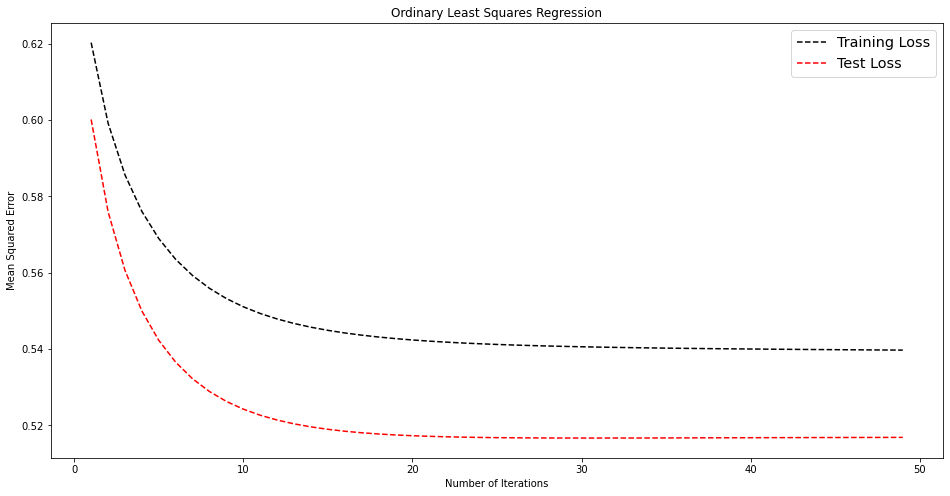

In [29]:
# take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

# Question 6: Cross Validation

In question 5 we mentioned that computing the loss after each iteration is not strictly a part of Gradient Descent, its just convenient for visualizing our progress. This "third step" however comes with a tradeoff: it requires an extra pass through the data. Normally this would cause us to cringe except for the fact that both the loss computation and the gradient computation are very easy to parallelize - lots of the work can be done in place no shuffle needed for the aggregation. 

[Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), sometimes called rotation estimation, or out-of-sample testing, is a model validation technique for assessing how well the model will generalize to an independent data set. The goal of cross-validation is to test the model's ability to predict new data. 

Cross validation, which will solve the problem of the unreliable test-loss that we saw in question 5, presents a bit more of a scalability challenge. To avoid over-dependence on a particulary good or bad test/train split we divide the data into `k` roughly equal size parts and train `k` models. The `k-th` model is trained on all the data _except_ the `k-th` split which is used as a test set for that model. Finally we compute the loss by averaging together the test/train loss for each model. In this question we've provided a code base to perform gradient descent and cross validation in parallel. You'll fill in some of the key details based on your understanding from questions 1-5.

#### From ISLR Chapter 5.1 - Cross Validation
<img src="https://github.com/kyleiwaniec/w261_assets/blob/master/images/CV-ISLRp181.png?raw=true">


### Q6 Tasks:
* __a) short response:__ A naive approach to training an OLS Regression model with cross validation might be to simply perform Gradient Descent on each of the 5 models in sequence. In this naive approach, how many total passes would be made over the data? [__`HINT:`__ _it will depend on factors that you should be able to name._]


* __b) short response:__ Read through the provided helper function `kResiduals()` and note where it gets used in the subsequent function `CVLoss()`. For each record in the original dataset, how many tuples does `kResiduals()` emit? What are the keys of these newly emitted records? How will these keys help us compute cross validated loss?


* __c) code:__ Complete the missing Spark code in `CVLoss()` so that this function returns the test/train cross validated error for a given set of data splits and their corresponding models. [__`TIP:`__ _your goal is to start from `partialLossRDD` and compute the test & train loss for each model so that the provided code can take the final average_].


* __d) code:__ Read through the provided functions `partialGradients()` and `CVUpdate()`. These should have a familiar feel. Fill in the missing line in `CVUpdate()` to update each model and add the (new) array of coefficients to the `new_models` list. 


* __e) short response:__ Read `GradientDescent_withCV()` and then run the provided code to perform 50 iterations and plot the error curves. What can you conclude from this graph?

### Q6 Student Answers:
> __a)__ We are basically running 5 models and choosing a different validation set on each model from the 5-fold equally split dataset. The naive way to think of it is running each of these models 1-after-each-other. In a non-parallelized way, we would run 5 models sequentially and then average the train/test loss of all these models. Each model needs to pass over the data twice, once for training and once for calculating the loss as mentioned in the intro to Q6. The data is $4/5$th the size of the original data because of the 5-fold cross validation. Therefore each model has $0.8 * 2 = 1.6$ passes over the data. **With 5 models we require $1.6*5 = 8$ total passes over the data.**

> __b)__ For each record in the original dataset, `kResiduals()` emits k tuples, one for each model. The newly emitted records have a composite key of "model_number-test/train" as their keys to help distinguish the squared error as calculated for a particular model while that point was in the train or test set. These keys help us compute cross validated loss by allowing us to aggregate same keys to combine losses for when model 1 through model k were test, and models 1 through model k were in train.   

> __e)__ This graph shows the average training and test loss for 5-fold cross validation. We see that the training loss is almost always lower than the test loss, even if our test loss is fairly close to the training loss. We can trust these results more than Q4's randomized test-train split and conclude that our model seems to work fairly well at minimizing training loss and generalizing based on the low test loss, though not as "well" as the Q4 last plot would misguide us into believing with its <0.52 MSE due to the particular test-train split in that problem. 5-fold cross validation reliably shows, agnostic of the test-train split, that test loss for our model is ~0.54 MSE. 

In [29]:
# part b - helper function to emit residuals (RUN THIS CELL AS IS)
def kResiduals(dataPoint, models, splitNum):
    """
    Compute the (squared) residuals for a data point given k different models.
    Note that points from the k-th split are part of the test set for model number k
    and part of the training set for all other models. We'll emit a key to track this.
    Args:
        dataPoint - tuple of (features_array, y)
        models    - list of arrays representing model weights (bias at index 0)
    Returns:
        (stringFormattedKey, squared_error)
    """
    # augment the data point with a bias term at index 0
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit squared residuals for each model
    for modelNum, W in enumerate(models):
        if modelNum == splitNum:
            yield(f"{modelNum}-test", (W.dot(X) - y)**2)
        else:
            yield(f"{modelNum}-train", (W.dot(X) - y)**2)

In [30]:
# part c - fill in the missing code below
def CVLoss(dataSplits, models):
    """
    Compute the k-fold cross-validated test and train loss.
    Args:
        dataSplits - list of RDDs corresponding to the k test splits.
        models     - list of k arrays representing model weights (bias at index 0)
    Returns: 
        tuple of floats: (training_loss, test_loss)
    """
    # compute k residuals for each dataPoint (one for each model)
    partialLossRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        residuals = splitRDD.flatMap(lambda x: kResiduals(x, models, splitNum))
        partialLossRDD = sc.union([partialLossRDD, residuals])
    
    ################ YOUR CODE HERE #################        
    loss = partialLossRDD.mapValues(lambda x: (x, 1)) \
                            .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
                            .mapValues(lambda x: x[0]/x[1]).collect()
    

    ################ (END) YOUR CODE ################# 
    
    test_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'test'])
    training_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'train'])
    return training_loss, test_loss

In [31]:
# part d - helper function RUN THIS CELL AS IS
def partialGradients(splitNum, dataPoint, models):
    """
    Emit partial gradient for this data point for each model.
    NOTE: a data point from split-number k is in the test set for 
    model-k so we don't compute a partial gradient for that model.
    """
    # augment the data point
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit partial gradients for each model with a counter for averaging later
    for modelNum, W in enumerate(models):
        if modelNum != splitNum:
            yield (modelNum, [(W.dot(X) - y)*X, 1])

In [32]:
# part d - perform GD updates for all k models (FILL IN MISSING CODE BELOW)
def CVUpdate(dataSplits, models, learningRate = 0.1):
    """
    Compute gradients for k models given k corresponding dataSplits.
    NOTE: the training set for model-k is all records EXCEPT those in the k-th split.
    """
    # compute partial gradient k-1 times for each fold
    partialsRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        thisFoldPartialGrads = splitRDD.flatMap(lambda x: partialGradients(splitNum, x, models))
        partialsRDD = sc.union([partialsRDD, thisFoldPartialGrads])

    # compute gradients by taking the average partialGrad for each fold
    gradients = partialsRDD.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                           .mapValues(lambda x: x[0]/x[1])\
                           .map(lambda x: x[1])\
                           .collect()
    
    # update all k models & return them in a list
    new_models = []
    for W, grad in zip(models, gradients):
        ############# YOUR CODE HERE ############
        new_model = W - learningRate*(2*grad) # update weights with learning rate and gradient*2 (because of eqn)
    
        new_models.append(new_model)
        ############# (END) YOUR CODE ###########
    return new_models

In [33]:
# part e - RUN THIS CELL AS IS
def GradientDescent_withCV(dataSplits, wInit, learningRate=0.1, nSteps = 5, verbose = False):
    """
    Train k models in parallel and track cross validated test/train loss.
    Returns:
        train_hist - (list) of floats
        test_hist - (list) of floats
        model_hist - (list) of arrays representing model coefficients (bias at index 0)
    """
    # broadcast initial models (one for each fold)
    bModels = sc.broadcast([wInit] * len(dataSplits))
    
    
    # initialize lists to track performance
    train_loss_0, test_loss_0 = CVLoss(dataSplits, bModels.value)
    train_hist, test_hist, model_hist = [train_loss_0], [test_loss_0], [wInit]
    
    # perform k gradient updates at a time (one for each fold)
    start = time.time()
    for step in range(nSteps):
        new_models = CVUpdate(dataSplits, bModels.value, learningRate)
           
        bModels = sc.broadcast(new_models)

        # log progress
        train_loss, test_loss = CVLoss(dataSplits, bModels.value)
        train_hist.append(train_loss)
        test_hist.append(test_loss)
        model_hist.append(new_models[0])
        
        if verbose:
            print("-------------------")
            print(f"STEP {step}: ")
            print(f"model 1: {[round(w,4) for w in new_models[0]]}")
            print(f" train loss: {round(train_loss,4)}")
            print(f" test loss: {round(test_loss,4)}")
            
    print(f"\n... trained {nSteps} iterations in {time.time() - start} seconds")
    return train_hist, test_hist, model_hist


In [34]:
# part d -  run 50 iterations (RUN THIS CELL AS IS)
dataSplits = normedRDD.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed = 2018) 
wInit = BASELINE
trainLoss, testLoss, models = GradientDescent_withCV(dataSplits, wInit, learningRate=0.1, nSteps = 50, verbose = False)


... trained 50 iterations in 78.75466823577881 seconds


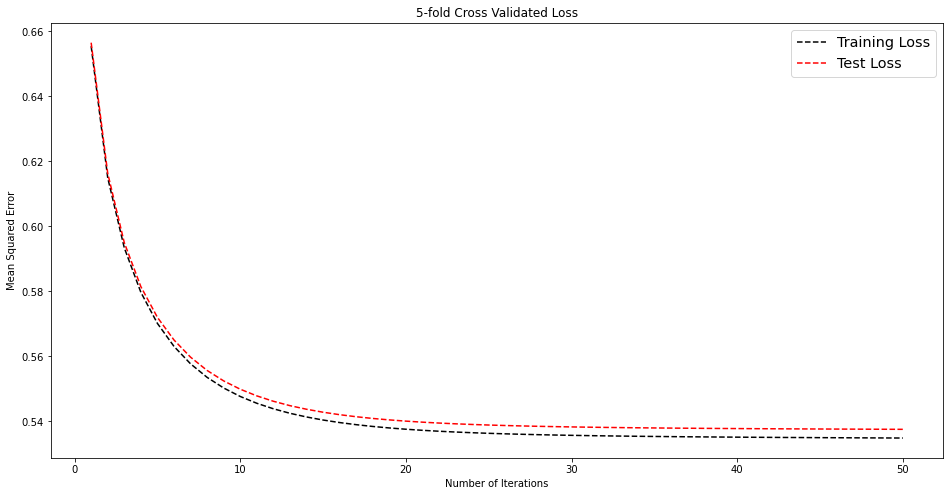

In [35]:
# part d - take a look (RUN THIS CELL AS IS)
plotErrorCurves(trainLoss, testLoss, title = '5-fold Cross Validated Loss' )

# Question 7: Regularization.

Our goal, as always, is to build a linear model that will extend well to unseen data. Chosing the right combination of features to optimize generalizability can be extremely computationally costly given that there are \\(2^{p}\\) potential models that can be built from \\(p\\) features. Traditional methods like forward selection would involve iteratively testing these options to asses which combinations of features achieve a statistically significant prediction.

Ridge Regression and Lasso Regression are two popular alternatives to OLS, which enable us to train generalizable models without the trouble of forward selection and/or manual feature selection.  Both methods take advantage of the bias-variance tradeoff by _shrinking_ the model coefficients towards 0 which reduces the variance of our model with little increase in bias. In practice this 'shrinkage' is achieved by adding a penalty (a.k.a. 'regularization') term to the means squared error loss function. In this question you will implement Gradient Descent with ridge and lasso regularization.

__`IMPORTANT NOTE:`__ When performing regularization _do not_ include the bias in your regularization term calcultion (Recall, that throughout this assignment we've included the bias at index 0 in the vector of weights that is your model).

### Q7 Tasks:
* __a) short response:__ The regularization term for ridge regression is the square of the \\(L2\\) norm of the weights vector (i.e. the sum of squares of the coefficients) times the regularization parameter, \\(\lambda\\). Write the formulas for both the loss function and the gradient for Ridge Regularization and explain what extra step this will add to our gradient descent algorithm.


* __b) short response:__ The regularization term for lasso regression is the \\(L1\\) norm of the weights vector (i.e. the sum of the absolute values of the coefficients) times the regularization parameter, \\(\lambda\\). Write the formulas for both the loss function and the gradient for Lasso Regularization and explain how the gradient descent update in Lasso will be different than it was in Ridge.


* __c) code:__ Fill in the first two missing code blocks in `GDUpdate_wReg()` so that this function will perform a single parameter update using \\(L2\\) regularization if the parameter `regType` is set to `ridge`, \\(L1\\) regularization if set to `lasso` and unregularized OLS otherwise.


* __d) code + short response:__ Use the provided code to train 50 iterations of ridge and lasso regression and plot the test/train error. Comment on the curves you see. Does this match your expectation?

### Q7 Student Answers:
> __a)__ 
>
> $$
\mathbf{x} :=
\begin{bmatrix}
1\\
\mathbf{x}
\end{bmatrix},\quad
\boldsymbol{\theta} :=
\begin{bmatrix}
b\\
\mathbf{w}
\end{bmatrix}
$$
>
> * **L2-regularization loss function:**
$$
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}_i - y_i\right]^2 + \lambda \sum_{j=1}^{m}\mathbf{w}_j^2$$
>
> * **L2-regularization gradient:**
$$
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}_i - y_i\right]\cdot\mathbf{x}_i + 2 \lambda \mathbf{w}$$
>
> * This adds the following extra step to our gradient descent algorithm: adding $2 \lambda$ times the model weight to the gradients of each weight (not including the bias) before updating the model.


> __b)__ Type your answer here!  
>
> $$
\mathbf{x} :=
\begin{bmatrix}
1\\
\mathbf{x}
\end{bmatrix},\quad
\boldsymbol{\theta} :=
\begin{bmatrix}
b\\
\mathbf{w}
\end{bmatrix}
$$
>
> * **L1-regularization loss function:**
$$
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}_i - y_i\right]^2 + + \lambda \sum_{j=1}^{m}|\mathbf{w}_j|$$
>
> * **L1-regularization gradient:**
$$
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}_i - y_i\right]\cdot\mathbf{x}_i + \lambda sign(\mathbf{w})$$
>
> * The gradient descent step for Lasso is different from Ridge because, in Lasso, we add a +/- $\lambda$, via `sign()`, to the gradients of each weight (not including the bias) before updating the model. The weights in Lasso can actually go to 0. 

> __d)__ Type your answer here!

In [36]:
# part c - gradient descent with regularization
def GDUpdate_wReg(dataRDD, W, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # augmented data
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    new_model = None
    #################### YOUR CODE HERE ###################
     # broadcast the weight vector W
    W_bc = sc.broadcast(W)
    
    def helper_get_partials(x: tuple):
        """
        Helper function to compute the data point weighted by the error on a row-by-row basis
        """
        pred = np.dot(W_bc.value, x[0])
        error = pred - x[1]
        data_weighted = np.dot(error, x[0])
        return data_weighted
        
    grad = (augmentedData.map(helper_get_partials).mean()) * 2 # gradient calculation
    
    if regType == 'ridge':
        grad += 2 * regParam * np.append([0.0], W[1:])
    elif regType == 'lasso':
        grad += regParam * np.append([0.0], np.sign(W)[1:])
    
    new_model = W - learningRate * grad
    
    
    ################## (END) YOUR CODE ####################
    return new_model

In [37]:
import numpy as np
W=np.array([1,-2,0,4])
print(2*np.append([0.0], W[1:]))
print(W)

wreg=np.sign(W)
wreg[0]=0
print(wreg)
print(W)

wReg = W * 1
wReg[-1] = 0
wReg=(wReg>0).astype(int) * 2-1
print(wReg)

[ 0. -4.  0.  8.]
[ 1 -2  0  4]
[ 0 -1  0  1]
[ 1 -2  0  4]
[ 1 -1 -1 -1]


In [38]:
# part d - ridge/lasso gradient descent function
def GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
        # update the model
        model = GDUpdate_wReg(trainRDD, model, learningRate, regType, regParam)
        
        # keep track of test/train loss for plotting
        train_history.append(OLSLoss(trainRDD, model))
        test_history.append(OLSLoss(testRDD, model))
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [39]:
# run 50 iterations of ridge (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
ridge_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50, 
                                     regType='ridge', regParam = 0.05 )
print(f"\n... trained {len(ridge_results[2])} iterations in {time.time() - start} seconds")


... trained 50 iterations in 11.714160919189453 seconds


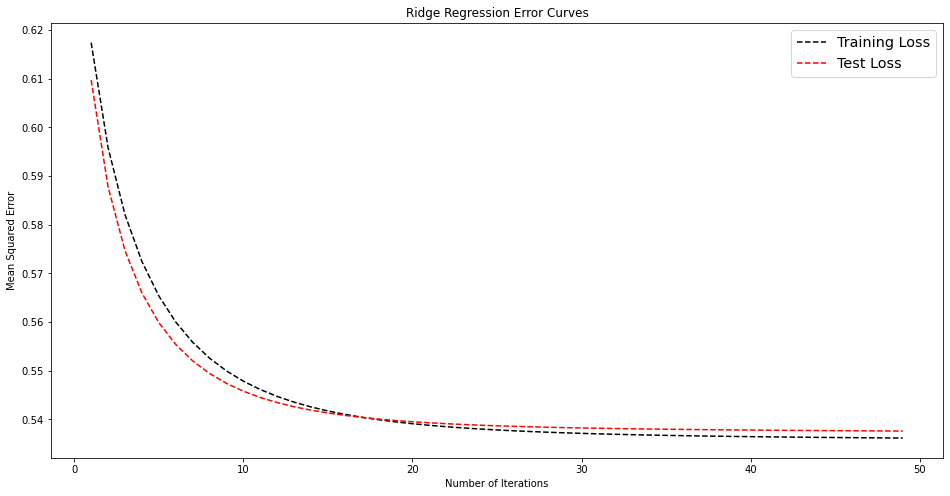

In [41]:
# part d - save and display ridge results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = ridge_results
np.savetxt(PWD + '/data/ridge_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/ridge_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Ridge Regression Error Curves' )
# plotErrorCurves(trainLoss, testLoss, title = 'Ridge Regression Error Curves' )

In [42]:
# run 50 iterations of lasso (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
lasso_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50,
                                     regType='lasso', regParam = 0.05)
print(f"\n... trained {len(lasso_results[2])} iterations in {time.time() - start} seconds")


... trained 50 iterations in 11.281282186508179 seconds


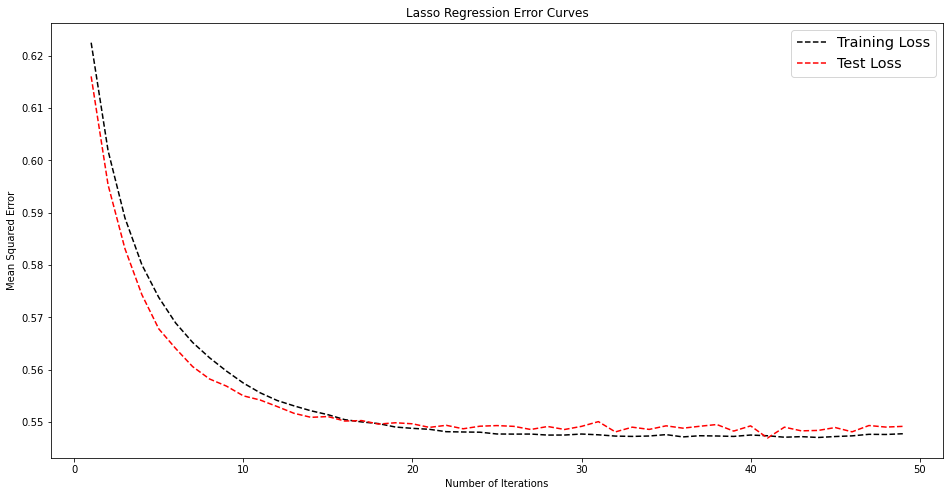

In [43]:
# part d - save and display lasso results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = lasso_results
np.savetxt(PWD + '/data/lasso_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/lasso_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Lasso Regression Error Curves' )
# plotErrorCurves(trainLoss, testLoss, title = 'Lasso Regression Error Curves' )

# Question 8: Results

In this final question we'll use a few different plots to help us compare the OLS, Ridge and Lasso models that we have trained. Use the provided code to load the training history from file and retrieve the best (i.e. last) model from each method.

### Q8 Tasks:
* __a) code:__ Use the provided code to load the training history from file and retrieve the best (i.e. last) model from each method. Then create a new RDD called `validationRDD` by computing the mean squared error on the held out dataset for each of the three models. [__`TIP:`__ _the held out data is in it's raw form, don't forget to parse and normalize before applying your calculations, you should also be careful to normalize using the same scaling parameters that you used for the training data._]

* __b) short response:__ Which model performed best? Discuss how you interpret these results and what you would want to try next.


* __c) short response:__ Use the provided code to plot side by side boxplots of the residuals vs. the outcome (i.e. `quality`). What can you observe about our model performance? [__`TIP:`__ _note that the heldout data set is plenty small enough to fit in memory so no need to sample. Feel free to do your plotting in pandas or any other comfortable python package._]


* __d) short response:__ Run the provided code to visualize the model coefficients for the first 50 iterations of training. What do you observe about how the OLS, ridge and lasso coefficients change over the course of the training process. Please be sure to discuss all three in your response.

### Q8 Student Answers:
> __b)__ Type your answer here!  

> __c)__ Type your answer here!  

> __d)__ Type your answer here!

In [44]:
# part a - load the models from file (RUN THIS CELL AS IS)
ols_models = np.loadtxt(PWD + '/data/OLSmodels.csv', dtype=float, delimiter=',')
ridge_models = np.loadtxt(PWD + '/data/ridge_models.csv', dtype=float, delimiter=',')
lasso_models = np.loadtxt(PWD + '/data/lasso_models.csv', dtype=float, delimiter=',')
best_ols = ols_models[-1,:]
best_ridge = ridge_models[-1,:]
best_lasso = lasso_models[-1,:]

In [55]:
# part a - compute MSE on the held out data for all three 'best' models
olsMSE, ridgeMSE, lassoMSE = None, None, None
validationRDD = None
############### YOUR CODE HERE #################
# parse the held out data
heldOutRDDParsed = heldOutRDD.map(parse)

# validationRDD needs to be normalized data of the held out dataset
# It must be normalized using the same scaling parameters used for the training data: normedRDD = normalize(trainRDDCached)

def normalizeTest(dataRDD, TrainRDD):
    """
    Scale and center test data round mean of each feature based on the scaling used on the train data
    Args:
        dataRDD - records are tuples of (features_array, y)
        TrainRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """
    featureMeans = TrainRDD.map(lambda x: x[0]).mean()
    featureStdev = np.sqrt(TrainRDD.map(lambda x: x[0]).variance())
        
    # normalize by subracting features by their means and dividing by their standard deviations
    normedRDD = dataRDD.map(lambda x: ((x[0]-featureMeans)/featureStdev, x[1]))    
    return normedRDD

validationRDD = normalizeTest(heldOutRDDParsed, trainRDDCached).cache()

# compute the MSE on this validationRDD using each of the 3 models
olsMSE = OLSLoss(validationRDD, best_ols)
ridgeMSE = OLSLoss(validationRDD, best_ridge)
lassoMSE = OLSLoss(validationRDD, best_lasso)


############### YOUR CODE HERE #################

print(f"OLS Mean Squared Error: {olsMSE}")
print(f"Ridge Mean Squared Error: {ridgeMSE}")
print(f"Lasso Mean Squared Error: {lassoMSE}")

OLS Mean Squared Error: 0.5529543649488734
Ridge Mean Squared Error: 0.5547695952730078
Lasso Mean Squared Error: 0.5624143772925653


In [56]:
# part c - helper function (RUN THIS CELL AS IS)
def get_residuals(dataRDD, model):
    """
    Return a collected list of tuples (residual, quality_score)
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    residuals = augmentedData.map(lambda x: (x[1] - model.dot(x[0]), x[1]))
    return residuals.collect()

In [57]:
# part c - compute residuals for all three models (RUN THIS CELL AS IS)
ols_resid = np.array(get_residuals(validationRDD, best_ols))
ridge_resid = np.array(get_residuals(validationRDD, best_ridge))
lasso_resid = np.array(get_residuals(validationRDD, best_lasso))

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


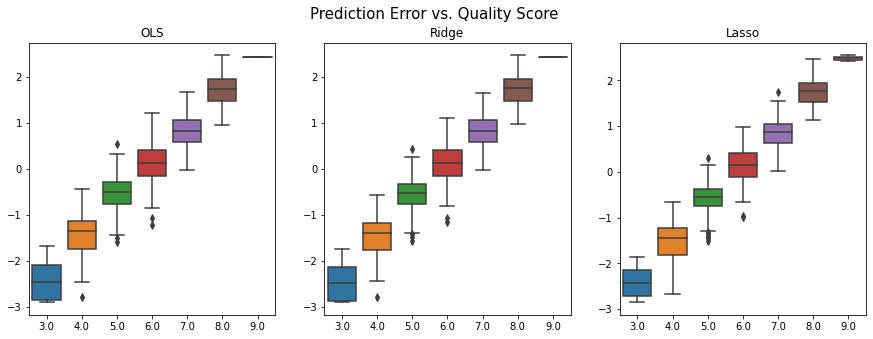

In [58]:
# # part c - boxplots of residuals for all three models (RUN THIS CELL AS IS)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
stuff_to_plot = zip(axes, ["OLS", "Ridge", "Lasso"], [ols_resid, ridge_resid, lasso_resid])
for ax, title, data in stuff_to_plot:
    ax.set_title(title)
    y = data[:, 0]
    x = data[:, 1]
    sns.boxplot(x, y, ax=ax)
fig.suptitle("Prediction Error vs. Quality Score", fontsize=15, y=0.98)
plt.show()

In [59]:
# part d - plotting function (RUN THIS CELL AS IS)
def plotCoeffs(models, featureNames, title):
    """
    Helper Function to show how coefficients change as we train.
    """
    fig, ax = plt.subplots(figsize = (15,8))
    X = list(range(len(models)))
    for data, name in zip(models.T, featureNames):
        if name == "Bias":
            continue
        ax.plot(X, data, label=name)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.legend()
    plt.show()

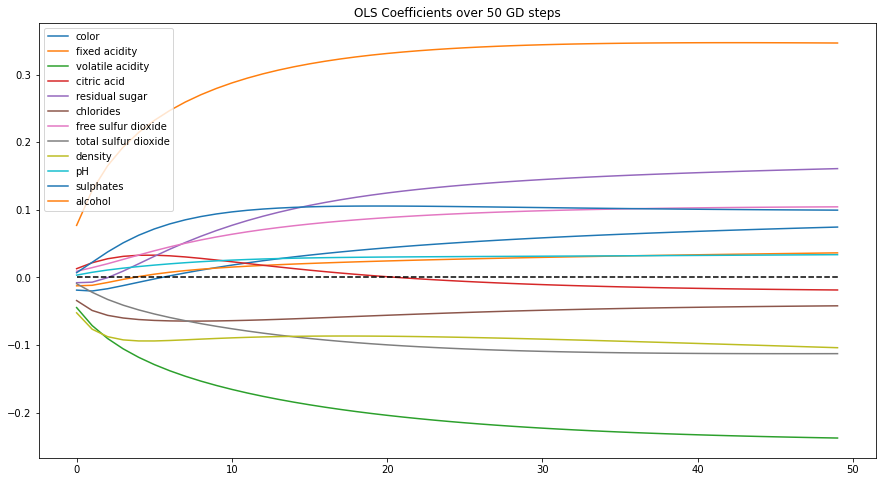

In [50]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ols_models, ['Bias'] + FIELDS, "OLS Coefficients over 50 GD steps")

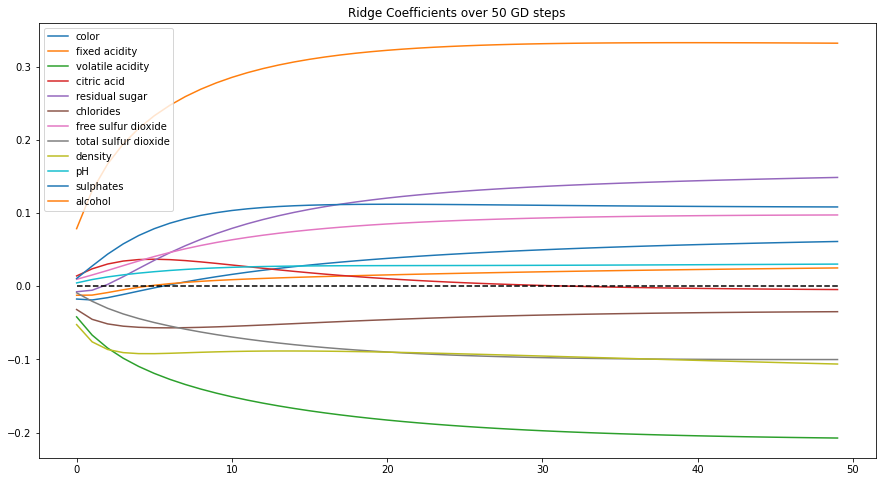

In [60]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ridge_models, ['Bias'] + FIELDS, "Ridge Coefficients over 50 GD steps")

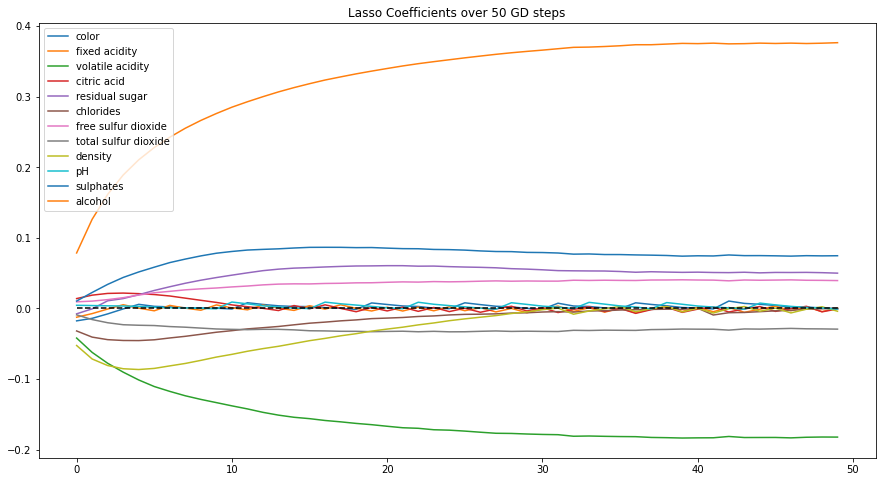

In [61]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(lasso_models, ['Bias'] + FIELDS, "Lasso Coefficients over 50 GD steps")

### Congratulations, you have completed HW4! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform